<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Analysis: Text Classification, Clustering, and Regression

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens.
* Using [Folium](https://pypi.org/project/folium/), [Geopy](https://geopy.readthedocs.io/en/stable/), and [scikit-learn](https://scikit-learn.org/stable/) algorithms for hierarchical clustering, classification and regression.

---


In [1]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
from collections import Counter
import nltk; nltk.download('stopwords')
import matplotlib.pyplot as plt

## Loading the data

In [2]:
import os

if not os.path.exists('proverbs.csv'):
    proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/proverbs.csv", index_col=0)
    proverbs.to_csv('proverbs.csv', index=False)
else:
    proverbs = pd.read_csv('proverbs.csv')

proverbs.shape


(134493, 4)

In [3]:
proverbs.sample(3)

text               place   
27833                           Όλος κι όλος μια πιθαμή  Θεσπρωτία, Κωστάνα  \
103060                       Το ένα κακό βγάζει τ' άλλο        Άδηλου τόπου   
42907   Ο Μάντης ρήας τζ' αν γενή, πάλε μαντιές μυρίζει     Κύπρος, Κυθραία   

                                              uri                   collector  
27833   http://hdl.handle.net/20.500.11853/213583  Ιωαννίδης, Κωνσταντίνος Θ.  
103060  http://hdl.handle.net/20.500.11853/268393              Ποταγός, Ν. Ν.  
42907   http://hdl.handle.net/20.500.11853/278627        Κολίτσης, Ανδρέας Μ.

* Few proverbs comrpise definitions, removing them

In [4]:
proverbs[proverbs.text.str.contains("=")].sample().text.item()

'Αθρωπομίλητος,η,ο = επί ζώων εχόντων ανθρωπίνων λαλιά κατα το παραμύθια ή εν γένει επί ζώων μοημόνων.'

In [5]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Also, duplicates exist.

In [6]:
proverbs[proverbs.duplicated()]

text   
62809         Απού δε θέλει χτύπους στο χαρκιδιό δεν πάει  \
62810   Απού δε σπείρη τον Οχτώβρη, οχτώ σωρούς δεν κάνει   
62811                     Απού διαλέει, πάει ποδιαλεμάτου   
62812   Απού δουλεύγει βασιλιά το νού ντου πρέπει νάχη...   
62813       Απού ζυμώση και πλυθή σαράντα μέρες είν' καλή   
...                                                   ...   
134488       Απ' ούλα τα φαΓια το ρύζ' και τσόχα να φορής   
134489  Απ' τ' Άη – Λιός και μπρός γυρίζει ο καιρός αλ...   
134490     Απ' τ' Άι – Ηλιά το βράδυ βάζει η ελιά το λάδι   
134491                        Απ' τ' άλουγου στου γουμάρι   
134492         Απ' τα ίδια κουμπιά κι' ολιγώτερη φαττούρα   

                                place   
62809     Κρήτη, Αποκόρωνας, Μελιδόνι  \
62810        Κρήτη, Λασίθι, Τζερμιάδο   
62811   Κρήτη, Λασίθι, Άγιος Γεώργιος   
62812                  Κρήτη, Ρέθυμνο   
62813   Κρήτη, Λασίθι, Άγιος Γεώργιος   
...                               ...   
134488                Θράκη, Σαμακόβι   
134489             Μεσσηνία, Φιλιατρά   
134490                         Σίφνος   
134491                        Ήπειρος   
134492                  Ηλεία, Πύργος   

                                              uri        collector  
62809   http://hdl.handle.net/20.500.11853/161130  Λιουδάκη, Μαρία  
62810   http://hdl.handle.net/20.500.11853/288692  Λιουδάκη, Μαρία  
62811   http://hdl.handle.net/20.500.11853/163118  Λιουδάκη, Μαρία  
62812   http://hdl.handle.net/20.500.11853/151409  Λιουδάκη, Μαρία  
62813   http://hdl.handle.net/20.500.11853/163084  Λιουδάκη, Μαρία  
...                                           ...              ...  
134488  http://hdl.handle.net/20.500.11853/245653        anonymous  
134489  http://hdl.handle.net/20.500.11853/160335        anonymous  
134490  http://hdl.handle.net/20.500.11853/190853        anonymous  
134491  http://hdl.handle.net/20.500.11853/159862        anonymous  
134492  http://hdl.handle.net/20.500.11853/199334        anonymous  

[13875 rows x 4 columns]

* There are more duplicates when considering the `text` column only.

In [7]:
num_total_duplicates = proverbs.text.duplicated().sum()
num_total_duplicates

24836

* Climbing up to the highest-level information per location labelled.

* In 'Κέρκυρα, Οθωνοί', for example, we only keep the first part of the term, using `split` to tokenise.

In [8]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs.sample(3)

text   
110973        Πολλοί παραμελούμενοι τσοιμώντουνε στον Άδη  \
71809                   Ανεμομαζώματα, διαβολοσκορπίσματα   
67148   Όποιος έχει πολλά παιδιά, έχει μιαν έγνοια κι'...   

                        place                                        uri   
110973         Αττική, Μέγαρα  http://hdl.handle.net/20.500.11853/253141  \
71809                   Κρήτη  http://hdl.handle.net/20.500.11853/152492   
67148   Κεφαλληνία, Αργοστόλι  http://hdl.handle.net/20.500.11853/245084   

                     collector        area  
110973           Σταμπόλας, Π.      Αττική  
71809     Λουλάκης, Σταύρος Μ.       Κρήτη  
67148   Λουκάτος, Δημήτριος Σ.  Κεφαλληνία

* One more observation regards proverbs with no information about their location 


In [9]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

# Geolocating

* There are 134 unique broad areas registered in the collection

In [10]:
locations = proverbs.area.unique()
len(locations)

134

* We will find the geographical coordinates of each one.

* Using [geopy](https://geopy.readthedocs.io/en/stable/#), which is a Python client for geocoding web services, locating the coordinates (e.g., of addresses, cities, countries) across the globe.

* This is already done and saved, but you can repeat this step by geocoding each location in the dataframe with the following code. Adding the country's name in the query improves the accuracy, but geolocation still doesn't work for all places. Hence, some are printed and fixed by hand.  

In [11]:
#@title [optional] Geocoding

if not os.path.exists('geolocs.csv'):
    from geopy.geocoders import Nominatim # import the library
    geolocator = Nominatim(user_agent="paremia") # initialise it

    geolocs = {}
    for loc in locations:
        # Avoiding polysemy by including "Greece" in the query
        location = geolocator.geocode(loc+ ", Ελλάδα") 
        if location:
            geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
        else:
            print (loc)

    # fixing some by hand (Cyprus was mislocated too)
    location = geolocator.geocode("Cyprus")
    geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Siteia")
    geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Chania")
    geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Nafpaktia")
    geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Lepenou")
    geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Cappadocia")
    geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Imathia")
    geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Boeotia")
    geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Edirne")
    geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
    geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phthiotis")
    geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Andritsaina")
    geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Dardanelles Strait")
    geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Central Greece")
    geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Areopoli")
    geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Trifylia")
    geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phocis")
    geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("West Mani")
    geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

    pd.DataFrame(geolocs).to_csv("geolocs.csv", index=False)

In [12]:
geolocs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/geolocs.csv") 
geolocs.index=["lat", "lon"]
geolocs

Κρήτη     Σίφνος     Σέρρες      Πήλιο    Ήπειρος    Λευκάδα   
lat  35.308495  36.971401  41.091071  39.365088  37.998253  38.706573  \
lon  24.463342  24.708110  23.549803  23.135561  23.737867  20.641709   

         Αχαΐα     Εύβοια  Μακεδονία     Κύπρος  ...  Ανατολική Θράκη   
lat  38.069275  38.494172  40.686024  34.982302  ...        41.675933  \
lon  21.872730  23.911084  23.693434  33.145128  ...        26.558722   

     Αδριανούπολη  Φθιώτιδα  Ανδρίτσαινα Ολυμπίου  Δαρδανέλλια (Ελλήσποντος)   
lat     41.675933  38.88734             37.483836                  40.337606  \
lon     26.558722  22.36803             21.905533                  26.640821   

     Στερεά Ελλάδα   Αερόπολη   Τριφυλία     Φωκίδα  Δυτική Μάνη  
lat      38.562460  36.665918  37.195013  38.499868    22.581762  
lon      23.161853  22.381635  21.703732  22.248780    88.399181  

[2 rows x 130 columns]

In [13]:
# turning it into a dict, our initial selection
geolocs = geolocs.to_dict()

* Now, updating the corpus with the mined information

In [14]:
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125222, 7)

# The anonymous collector
* Not all proverbs were collected by named individuals.

In [15]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


# Duplicates

* Focusing on proverbs shared among locations.

* Using ones by named collectors.

* While the areas of the duplicates collected by anonymous individuals are not many.

In [16]:
num_named_duplicates = named.text.duplicated().sum()
num_anonymous_duplicates = anonymous.text.duplicated().sum()
num_sum_duplicates = num_named_duplicates + num_anonymous_duplicates
num_total_duplicates = proverbs.text.duplicated().sum()
print(f'Only {num_named_duplicates} duplicate proverbs from named collectors')
print(f'while {num_anonymous_duplicates} are from the anonymous collector')
print(f'Sum is {num_sum_duplicates} out of {num_total_duplicates} total duplicates')
print(f'Diff is {num_total_duplicates - num_sum_duplicates}')

Only 10861 duplicate proverbs from named collectors
while 13868 are from the anonymous collector
Sum is 24729 out of 24836 total duplicates
Diff is 107


* The difference above between the total duplicates and the sum of the named and the anonymous duplicates is explained by the existence of duplicates between named and anonymous.

In [17]:
pd.merge(named, anonymous, how='inner', on='text').text.unique().shape

(107,)

* The duplicates from the named collectors concern 104 locations.

In [18]:
named[named.text.duplicated()].area.unique()

array(['Εύβοια', 'Λέσβος', 'Ήπειρος', 'Ρούμελη', 'Κοζάνη', 'Αρκαδία',
       'Ίμβρος', 'Φιλιππούπολη', 'Αττική', 'Πόντος',
       'Δαρδανέλλια (Ελλήσποντος)', 'Θράκη', 'Μακεδονία', 'Κεφαλληνία',
       'Μήλος', 'Χίος', 'Μικρά Ασία', 'Κρήτη', 'Κίμωλος', 'Άνδρος',
       'Λέρος', 'Ρόδος', 'Κύπρος', 'Άρτα', 'Πρέβεζα', 'Παξοί', 'Καρδίτσα',
       'Άδηλου τόπου', 'Καστελλόριζο (Μεγίστη)', 'Αθήνα', 'Μεσσηνία',
       'Λακωνία', 'Σίφνος', 'Ηλεία', 'Σύμη', 'Θήρα (Σαντορίνη)', 'Κως',
       'Σμύρνη', 'Κάλυμνος', 'Νάξος', 'Αδριανούπολη', 'Ευρυτανία',
       'Κέρκυρα', 'Αμοργός', 'Θεσπρωτία', 'Σάμος', 'Καστοριά', 'Βοιωτία',
       'Επτάνησος', 'Νίσυρος', 'Αχαΐα', 'Κορινθία', 'Τήλος', 'Πέλλα',
       'Λάρισα', 'Κύθηρα', 'Ιωάννινα', 'Ημαθία', 'Φωκίδα', 'Πελοπόννησος',
       'Σύρος', 'Μάνη', 'Σκύρος', 'Αιτωλία', 'Κύθνος', 'Τήνος', 'Κέα',
       'Άγιον Όρος', 'Πάρος', 'Θεσσαλία', 'Μάλγαρα', 'Ανατολική Κρήτη',
       'Μαγνησία', 'Σέριφος', 'Ιθάκη', 'Λευκάδα', 'Αργολίδα',
       'Καππαδοκία', 'Ακαρναν

* We group by text the `named` duplicates , to get duplicates using items by named collectors.

In [19]:
grouping = named[named.lat.notna() & named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.apply(set)})
duplicates["place_num"] = duplicates.place.apply(len)
duplicates.sort_values(by="place_num", ascending=False)[:3]

place   
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Ρούμελη, Πήλιο, Ζαγορά, Ήπειρος, Κύπρος, Λευκ...  \
Ανεμομαζώματα, διαβολοσκορπίσματα               {Ήπειρος, Μικρά Ασία, Κύζικος, Αρτάκη, Ήπειρος...   
Θεωρία επισκόπου και καρδιά μυλωνά              {Ήπειρος, Ιθάκη, Μακεδονία, Καταφύγι, Ιωάννινα...   

                                                place_num  
text                                                       
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει         45  
Ανεμομαζώματα, διαβολοσκορπίσματα                      28  
Θεωρία επισκόπου και καρδιά μυλωνά                     27

* Finding the broader location, which we'll call `area`.

In [20]:
duplicates["area"] = duplicates.place.map(lambda x: {i.split(",")[0] for i in x})
duplicates["area_num"] = duplicates.area.apply(len)
duplicates.sort_values(by="area_num", ascending=False)[:3]

place   
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Ρούμελη, Πήλιο, Ζαγορά, Ήπειρος, Κύπρος, Λευκ...  \
Στου κουφού την πόρτα όσο θέλεις βρόντα         {Ρούμελη, Άνδρος, Κοζάνη, Βόϊο, Διαλεκτό, Καστ...   
Ανεμομαζώματα, διαβολοσκορπίσματα               {Ήπειρος, Μικρά Ασία, Κύζικος, Αρτάκη, Ήπειρος...   

                                                place_num   
text                                                        
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει         45  \
Στου κουφού την πόρτα όσο θέλεις βρόντα                26   
Ανεμομαζώματα, διαβολοσκορπίσματα                      28   

                                                                                             area   
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Ρούμελη, Ήπειρος, Εύβοια, Νίσυρος, Αρκαδία, Μ...  \
Στου κουφού την πόρτα όσο θέλεις βρόντα         {Ρούμελη, Άνδρος, Αρκαδία, Νίσυρος, Ιωάννινα, ...   
Ανεμομαζώματα, διαβολοσκορπίσματα               {Ήπειρος, Δαρδανέλλια (Ελλήσποντος), Εύβοια, Α...   

                                                area_num  
text                                                      
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει        23  
Στου κουφού την πόρτα όσο θέλεις βρόντα               20  
Ανεμομαζώματα, διαβολοσκορπίσματα                     18

In [21]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 105612 unique texts, 3204 exist in multiple areas


* We'll focus on proverbs common across `area`s.

In [22]:
duplicates = duplicates[duplicates.area_num>1]

* We add the geographical coordinates in the duplicates.

* We want a list per proverb, given that there is an 1:n mapping between proverbs and areas.

In [23]:
coordinates = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                             for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample()

place  place_num              area  area_num   
text                                                                         
Μαϊμού του Κωλέτη  {Αθήνα, Λακωνία}          2  {Αθήνα, Λακωνία}         2  \

                                                              latlon  
text                                                                  
Μαϊμού του Κωλέτη  [(37.9839412, 23.7283052), (36.76027945, 22.79...

In [24]:
# saving
duplicates.to_pickle("duplicates_geolocated.csv")

* Let's visualising the dataframe.

* We will use [Folium](https://python-visualization.github.io/folium), which is based on [leaflet](https://leafletjs.com/), an open-source JavaScript library for mobile-friendly interactive maps. 

* Note that outliers exist: Chiesa della Madona delle Neve

In [25]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)

for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)

m.save("duplicates.html")
m

* Let's find the number of areas sharing proverbs with crowdy Athens

In [26]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


# Single-placed proverbs

In [27]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
print(proverbs_sp.shape[0])
proverbs_sp.sample(3)

100879


text         place   
6694                       Ντουλαπιάζω        Άνδρος  \
22626  Θα κάμη (ήκαμε) τάχερα κομμάτια       Αμοργός   
46565         Αυτή είναι πικραγγουργιά  Αχαΐα, Πάτρα   

                                             uri             collector   
6694   http://hdl.handle.net/20.500.11853/287981    Βογιατζίδης, Ι. Κ.  \
22626  http://hdl.handle.net/20.500.11853/269499  Ιωαννίδης, Εμμανουήλ   
46565  http://hdl.handle.net/20.500.11853/212110  Κορύλλος, Χρήστος Π.   

          area        lat        lon  
6694    Άνδρος  37.840835  24.862382  
22626  Αμοργός  36.852524  25.898487  
46565    Αχαΐα  38.069275  21.872730

* We'll move aside single-placed proberbs from an unknown place.

In [28]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


text         place   
53934      Κάθε πετεινός στο μπουκλούκι του  Άδηλου τόπου  \
73303   Είναι να την πιης μέσ' 'ς το ποτήρι  Άδηλου τόπου   
102909             Όλι οι γύφτοι μια σειριά  Άδηλου τόπου   

                                              uri               collector   
53934   http://hdl.handle.net/20.500.11853/169040         Κουμανούδης, Π.  \
73303   http://hdl.handle.net/20.500.11853/204338  Μανασσείδης, Συμεών Α.   
102909  http://hdl.handle.net/20.500.11853/265255          Ποταγός, Ν. Ν.   

                area  lat  lon  
53934   Άδηλου τόπου  NaN  NaN  
73303   Άδηλου τόπου  NaN  NaN  
102909  Άδηλου τόπου  NaN  NaN

* We'll work with the rest.

In [29]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


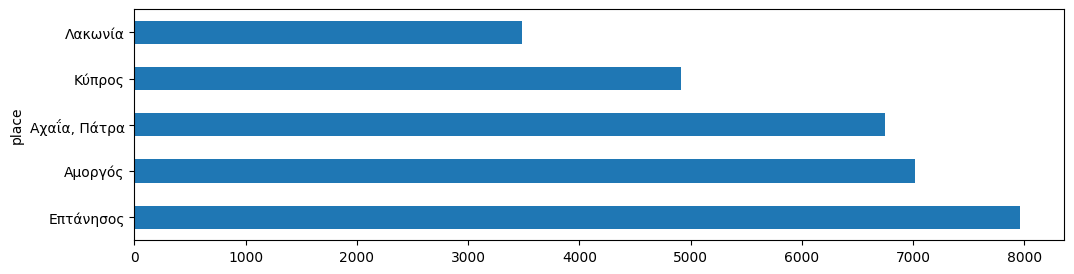

In [30]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(12,3));

* Let's visualise the places along with the number of proverbs collected there.

In [31]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(",")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html')
m

* Next, we'll work with places which have 1,000 or more proverbs, allowing sampling without class imbalance issues.

In [32]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


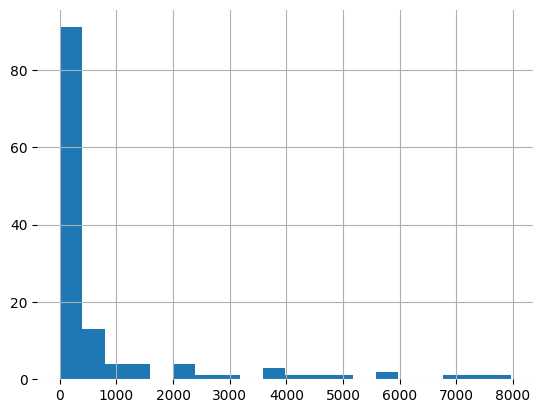

In [33]:
placed_pd.length.hist(bins=20);
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000.

In [34]:
common_places = placed_pd[placed_pd.length>=1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


* We'll remove proverbs with unknown (invalid?) characters.

In [35]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* We create a location-balanced corpus.

In [36]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TF * IDF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across all places are more important (IDF). 

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, min_df=1, lowercase=True)
X = vect.fit_transform(long_texts)

In [39]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [40]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area  Ήπειρος  Αιτωλία  Αμοργός  Ανατολική Θράκη  Αρκαδία  Αχαΐα  Επτάνησος   
τζ        0.0      0.0      0.0              0.0      0.0    0.0   0.032478  \
τζαι      0.0      0.0      0.0              0.0      0.0    0.0   0.000000   
τζαί      0.0      0.0      0.0              0.0      0.0    0.0   0.000000   

area    Εύβοια  Θεσπρωτία  Θράκη  ...  Κρήτη    Κύπρος  Λέσβος  Λακωνία   
τζ    0.016188        0.0    0.0  ...    0.0  0.632745     0.0      0.0  \
τζαι  0.000000        0.0    0.0  ...    0.0  0.407238     0.0      0.0   
τζαί  0.000000        0.0    0.0  ...    0.0  0.343385     0.0      0.0   

area  Μακεδονία  Μικρά Ασία     Νάξος  Πόντος  Ρόδος  Σκύρος  
τζ          0.0    0.000000  0.015551     0.0    0.0     0.0  
τζαι        0.0    0.022671  0.000000     0.0    0.0     0.0  
τζαί        0.0    0.000000  0.000000     0.0    0.0     0.0  

[3 rows x 23 columns]

* Computing a lexicon with the terms with the highest TFIDF value per area

In [41]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
area_ngrams

{'Ήπειρος': ['τουν', 'έβρεχε', 'τούν'],
 'Αιτωλία': ['τουν', 'είνι', 'μι'],
 'Αμοργός': ['μηδέ', 'μήδε', 'κάλλιον'],
 'Ανατολική Θράκη': ['έβαλε', 'γάϊδαρο', 'νε'],
 'Αρκαδία': ['ρε', 'μούδωκες', 'ήρθε'],
 'Αχαΐα': ['τογ', 'τομ', 'στογ'],
 'Επτάνησος': ['ναν', 'θαν', 'τσου'],
 'Εύβοια': ['τσαί', 'τσαι', 'μήτε'],
 'Θεσπρωτία': ['βλέπει', 'γομάρι', 'γύφτοι'],
 'Θράκη': ['δι', 'σι', 'μι'],
 'Ιωάννινα': ['μι', 'τουν', 'σι'],
 'Κάρπαθος': ['εγιώ', 'τσαί', 'τσαι'],
 'Κεφαλληνία': ['τση', 'τσου', 'δείρε'],
 'Κρήτη': ['ντου', 'ίντα', 'τση'],
 'Κύπρος': ['τζ', 'τζαι', 'τζαί'],
 'Λέσβος': ['τσι', 'τουν', 'είνι'],
 'Λακωνία': ['μεγαλώνει', 'μεγάλη', 'ράφτης'],
 'Μακεδονία': ['μι', 'σι', 'κούρευαν'],
 'Μικρά Ασία': ['τουν', 'είνιν', 'κη'],
 'Νάξος': ['τζη', 'εώ', 'ια'],
 'Πόντος': ['σο', 'ατ', 'σην'],
 'Ρόδος': ['κάττα', 'είνε', 'μηέ'],
 'Σκύρος': ['τσαί', 'τσαι', 'έναι']}

* Locating the important terms on the map

In [42]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html'); m

In [43]:
geotfidf.to_csv("geotfidf.csv")

In [44]:
pd.DataFrame(area_ngrams)

Ήπειρος Αιτωλία  Αμοργός Ανατολική Θράκη   Αρκαδία Αχαΐα Επτάνησος Εύβοια   
0    τουν    τουν     μηδέ           έβαλε        ρε   τογ       ναν   τσαί  \
1  έβρεχε    είνι     μήδε         γάϊδαρο  μούδωκες   τομ       θαν   τσαι   
2    τούν      μι  κάλλιον              νε      ήρθε  στογ      τσου   μήτε   

  Θεσπρωτία Θράκη  ... Κρήτη Κύπρος Λέσβος    Λακωνία Μακεδονία Μικρά Ασία   
0    βλέπει    δι  ...  ντου     τζ    τσι  μεγαλώνει        μι       τουν  \
1    γομάρι    σι  ...  ίντα   τζαι   τουν     μεγάλη        σι      είνιν   
2    γύφτοι    μι  ...   τση   τζαί   είνι     ράφτης  κούρευαν         κη   

  Νάξος Πόντος  Ρόδος Σκύρος  
0   τζη     σο  κάττα   τσαί  
1    εώ     ατ   είνε   τσαι  
2    ια    σην    μηέ   έναι  

[3 rows x 23 columns]

In [45]:
loc_name = {'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Macedonia', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
for area in area_ngrams:
    print(f'{loc_name[area]} & {" & ".join(area_ngrams[area])} \\\\')

Epirus & τουν & έβρεχε & τούν \\
Etolia & τουν & είνι & μι \\
Amorgos & μηδέ & μήδε & κάλλιον \\
East Thrace & έβαλε & γάϊδαρο & νε \\
Arcadia & ρε & μούδωκες & ήρθε \\
Achaia & τογ & τομ & στογ \\
Eptanisos & ναν & θαν & τσου \\
Eyvoia & τσαί & τσαι & μήτε \\
Thesprotia & βλέπει & γομάρι & γύφτοι \\
Thrace & δι & σι & μι \\
Ioannina & μι & τουν & σι \\
Karpathos & εγιώ & τσαί & τσαι \\
Kefalinia & τση & τσου & δείρε \\
Crete & ντου & ίντα & τση \\
Cyprus & τζ & τζαι & τζαί \\
Lesvos & τσι & τουν & είνι \\
Laconia & μεγαλώνει & μεγάλη & ράφτης \\
Macedonia & μι & σι & κούρευαν \\
Asia Minor & τουν & είνιν & κη \\
Naxos & τζη & εώ & ια \\
Pontos & σο & ατ & σην \\
Rodos & κάττα & είνε & μηέ \\
Skyros & τσαί & τσαι & έναι \\


# Authorship analysis
* Training one language model per area, by sampling proverbs of that area



In [46]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [47]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

In [48]:
# building the local language models
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[area] = LM(gram="CHAR").train(" \n ".join(texts))

In [49]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {loc:[models[loc].cross_entropy(proverb.lower())] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [50]:
# use case
loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

Ήπειρος  Κεφαλληνία   Αρκαδία  Ανατολική Θράκη   Λακωνία  Θεσπρωτία   
0  3.143337    3.176735  3.812387         3.836257  4.057931   4.071108  \

   Επτάνησος  Μικρά Ασία  Ιωάννινα     Κρήτη  ...    Εύβοια     Ρόδος   
0   4.084588    4.100812  4.318953  4.341643  ...  4.512733  4.590336  \

      Θράκη  Κάρπαθος   Αμοργός    Σκύρος    Λέσβος   Αιτωλία    Κύπρος   
0  4.877212  4.877456  5.047279  5.311574  5.454145  5.618857  5.705394  \

     Πόντος  
0  6.073986  

[1 rows x 23 columns]

In [51]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Τη κότσινημ Πέφτην, τζαι  τάσπρον Σάββατον (Κύπρος) -- predicted as: Κύπρος


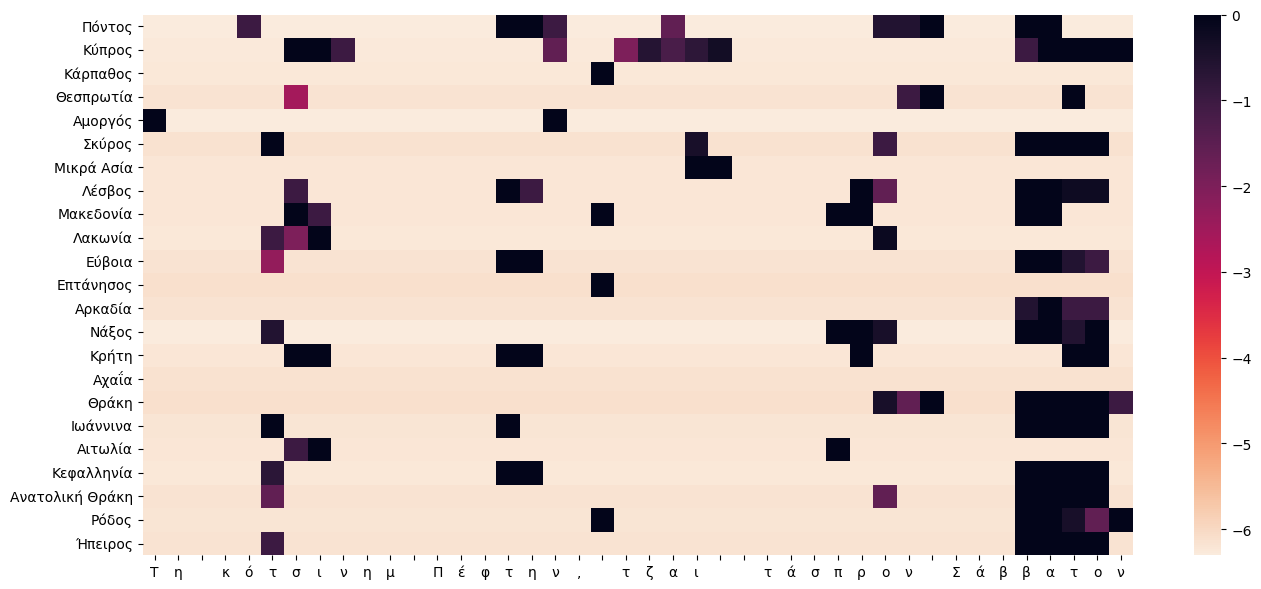

In [52]:
t = test[test.area=="Κύπρος"].sample().iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
ax.figure.tight_layout(); ax.figure.savefig("heatmap.pdf", format="PDF", dpi=300)

* Evaluating on unseen proverbs

In [53]:
from sklearn.metrics import *
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
print(classification_report(test.area.values, predictions, zero_division=0))

                 precision    recall  f1-score   support

        Ήπειρος       0.17      0.13      0.15        23
        Αιτωλία       0.50      0.33      0.40        24
        Αμοργός       0.33      0.23      0.27        22
Ανατολική Θράκη       0.11      0.08      0.09        24
        Αρκαδία       0.07      0.06      0.07        31
          Αχαΐα       0.24      0.25      0.25        32
      Επτάνησος       0.29      0.48      0.36        23
         Εύβοια       0.15      0.25      0.19        20
      Θεσπρωτία       0.03      0.05      0.03        22
          Θράκη       0.04      0.04      0.04        25
       Ιωάννινα       0.24      0.14      0.17        29
       Κάρπαθος       0.34      0.39      0.37        28
     Κεφαλληνία       0.23      0.33      0.27        27
          Κρήτη       0.26      0.27      0.26        30
         Κύπρος       0.88      0.62      0.73        24
         Λέσβος       0.33      0.12      0.18        24
        Λακωνία       0.08    

* The confusion matrix can inform us about the confusion in the predictions

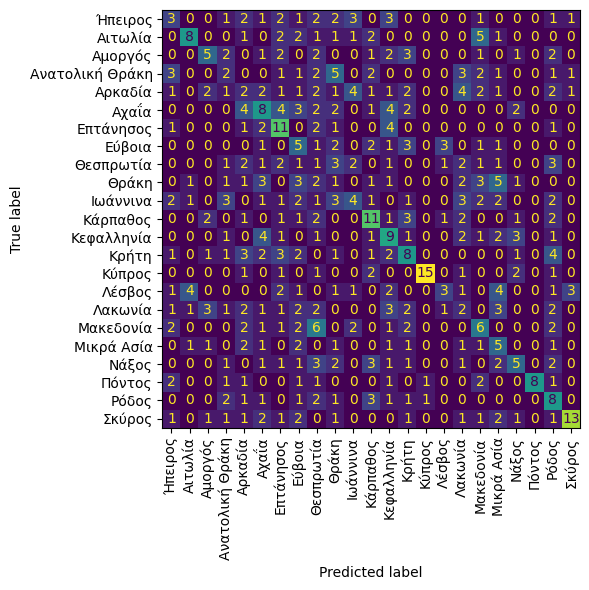

In [54]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(test.area.values, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

# Text spatial classification
* Trying with a standard text classifier improves slightly the accuracy but similar findings are reported

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier

Learning a location classifier on top of character n-grams

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

n-gram: "ία" 	(tfidf: 0.16)
n-gram: "αρ" 	(tfidf: 0.09)
n-gram: "αρο" 	(tfidf: 0.17)
n-gram: "αροι" 	(tfidf: 0.29)
n-gram: "αροιμ" 	(tfidf: 0.30)
n-gram: "ιμ" 	(tfidf: 0.15)
n-gram: "ιμί" 	(tfidf: 0.27)
n-gram: "μί" 	(tfidf: 0.16)
n-gram: "μία" 	(tfidf: 0.24)
n-gram: "οι" 	(tfidf: 0.11)
n-gram: "οιμ" 	(tfidf: 0.22)
n-gram: "οιμί" 	(tfidf: 0.30)
n-gram: "πα" 	(tfidf: 0.09)
n-gram: "παρ" 	(tfidf: 0.14)
n-gram: "παρο" 	(tfidf: 0.28)
n-gram: "παροι" 	(tfidf: 0.30)
n-gram: "ρο" 	(tfidf: 0.10)
n-gram: "ροι" 	(tfidf: 0.21)
n-gram: "ροιμ" 	(tfidf: 0.30)
n-gram: "ροιμί" 	(tfidf: 0.30)


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

# benchmarking text classification algorithms
def benchmark_clf(train, dev, test):
    for algo_name, algorithm in (('SVM', LinearSVC), 
                                 ('Forest', RandomForestClassifier), 
                                 ('LR', LogisticRegression)):
        locator = Pipeline([('vect', vect), ('clf', algorithm())]) 
        locator.fit(train.text.values, train.area.values) 
        txt_preds = locator.predict(dev.text.values) 
        print(f'{algo_name}: {accuracy_score(dev.area.values, txt_preds):.3f}') # <- accuracy is fine for balanced data

benchmark_clf(train, dev, test)

SVM: 0.296
Forest: 0.226
LR: 0.287


In [58]:
# training and assessing the best model on test data
from sklearn.svm import SVC
locator = Pipeline([('vect', vect), ('clf', LogisticRegression())]) 
locator.fit(train.text.values, train.area.values) 
predictions = locator.predict(test.text.values) 
print(classification_report(test.area.values, predictions))

                 precision    recall  f1-score   support

        Ήπειρος       0.15      0.09      0.11        23
        Αιτωλία       0.41      0.54      0.46        24
        Αμοργός       0.38      0.45      0.42        22
Ανατολική Θράκη       0.31      0.21      0.25        24
        Αρκαδία       0.12      0.10      0.11        31
          Αχαΐα       0.40      0.31      0.35        32
      Επτάνησος       0.37      0.61      0.46        23
         Εύβοια       0.15      0.20      0.17        20
      Θεσπρωτία       0.12      0.18      0.15        22
          Θράκη       0.22      0.08      0.12        25
       Ιωάννινα       0.21      0.14      0.17        29
       Κάρπαθος       0.48      0.43      0.45        28
     Κεφαλληνία       0.19      0.19      0.19        27
          Κρήτη       0.28      0.23      0.25        30
         Κύπρος       0.76      0.92      0.83        24
         Λέσβος       0.33      0.42      0.37        24
        Λακωνία       0.13    

# Classifying multi-located proverbs

* Such a classifier can give an estimate about the origins of proverbs multiply located  

In [59]:
duplicates.insert(4, "prediction", locator.predict(duplicates.index.values))
probs = locator.predict_proba(duplicates.index.values)
duplicates.insert(5, "confidence", probs.max(1))
duplicates.reset_index().to_excel("sayings_duplicated_located.xlsx", index=False)
duplicates.sort_values(by="confidence", ascending=False).head(20)

place   
text                                                                                                  
Πάρτ' τουν στου γάμου σ' να σ' πη κι τ' χρόν'                             {Σάμος, Ήπειρος, Δολιανά}  \
Μ' πήρι τ' αυτιά                                               {Ιωάννινα, Νεγάδες, Ήπειρος, Ζαγόρι}   
Πίσου είνι του πουτήρ' μι τ' ρίγαν'                   {Αρκαδία, Γορτυνία, Λάστα, Αιτωλία, Αμβρακιά}   
Εδώκαν άτον πρόσωπον και θέλει και τ' αστάριν                                {Πόντος, Αδριανούπολη}   
Γέρασι κι γνώσ' στου κιφάλ' τ' δεν έβαλε                       {Ιωάννινα, Νεγάδες, Ήπειρος, Ζαγόρι}   
Αυτός είνι κατέβα να φάμι                                    {Λέσβος, Πλωμάρι, Σάμος, Μαραθόκαμπος}   
Αυτός είναι ανεμόμυλος                            {Μικρά Ασία, Κυδωνία, Αχαΐα, Πάτρα, Ανατολική ...   
Αυτός είναι μη μου άπτου                                               {Ιωάννινα, Νεγάδες, Αμοργός}   
Ένας νους κι' αυτός ρωμαίϊκος                                {Αδριανούπολη, Ήπειρος, Ζαγόρι, Βίτσα}   
Άσκουπους ου νους διπλός ου κόπους                            {Ιωάννινα, Νεγάδες, Ήπειρος, Δολιανά}   
Αρνί που βλέπει ο Θεός, ο λύκος δεν δεν το τρώει  {Μακεδονία, Γρεβενά, Βάρη, Πρέβεζα, Πάργα, Καρ...   
Τουμ πέθανι στου ξύλου                                         {Ιωάννινα, Νεγάδες, Ήπειρος, Ζαγόρι}   
Δεν έχ' νύχια να ξυθή                                      {Αδριανούπολη, Ιωάννινα, Μέγα Περιστέρι}   
Μασά τα λόγια του                                                           {Θράκη, Αίνος, Αμοργός}   
Κάτσι στ' αυγά σ'                                        {Μικρά Ασία, Αδραμύττιο, Ήπειρος, Δολιανά}   
Τα λόγια κουμέρκι δεν έχουν                                                     {Θεσσαλία, Λακωνία}   
Άνθρουπους αγράμματους ξύλου απιλέκητου                                      {Αδριανούπολη, Σέρρες}   
Μεγαλώνει το μουλάρι και κονταίνει το σαμάρι                    {Πόντος, Δαρδανέλλια (Ελλήσποντος)}   
Το γινάτ' βγάζ' το μάτ'                           {Θράκη, Σαράντα Εκκλησίες, Κοζάνη, Βόϊο, Γαλατ...   
Αν δεν είν' εκείνος εδέπα, είν' ο αγγελός του                           {Αρκαδία, Γορτυνία, Κύπρος}   

                                                  place_num   
text                                                          
Πάρτ' τουν στου γάμου σ' να σ' πη κι τ' χρόν'             2  \
Μ' πήρι τ' αυτιά                                          2   
Πίσου είνι του πουτήρ' μι τ' ρίγαν'                       2   
Εδώκαν άτον πρόσωπον και θέλει και τ' αστάριν             2   
Γέρασι κι γνώσ' στου κιφάλ' τ' δεν έβαλε                  2   
Αυτός είνι κατέβα να φάμι                                 2   
Αυτός είναι ανεμόμυλος                                    3   
Αυτός είναι μη μου άπτου                                  2   
Ένας νους κι' αυτός ρωμαίϊκος                             2   
Άσκουπους ου νους διπλός ου κόπους                        2   
Αρνί που βλέπει ο Θεός, ο λύκος δεν δεν το τρώει          2   
Τουμ πέθανι στου ξύλου                                    2   
Δεν έχ' νύχια να ξυθή                                     2   
Μασά τα λόγια του                                         2   
Κάτσι στ' αυγά σ'                                         2   
Τα λόγια κουμέρκι δεν έχουν                               2   
Άνθρουπους αγράμματους ξύλου απιλέκητου                   2   
Μεγαλώνει το μουλάρι και κονταίνει το σαμάρι              2   
Το γινάτ' βγάζ' το μάτ'                                   2   
Αν δεν είν' εκείνος εδέπα, είν' ο αγγελός του             2   

                                                                                  area   
text                                                                                     
Πάρτ' τουν στου γάμου σ' να σ' πη κι τ' χρόν'                         {Σάμος, Ήπειρος}  \
Μ' πήρι τ' αυτιά                                                   {Ήπειρος, Ιωάννινα}   
Πίσου είνι του πουτήρ' μι τ' ρίγαν'                                 {Αρκαδία, Αι

# Regression on the coordinates
* Instead of classifying the place, we can learn to predict the geographical coordinates.
* By using linear regression, we can measure feature importance afterwards, n-grams which distinguish spatially, from South to North, from West to East. 

In [60]:
linear = Pipeline([('vect', vect), ('reg', LinearRegression())])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

* R2 is the coefficient of determination, measuring how well a statistical model predicts the model's dependent variable (the outcome).

In [61]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

R2 (train): 1.000
R2 (dev): -0.068


In [62]:
predicted_coords = linear.predict(test.text.values)
print(f"MAE of lat and lon: {mean_absolute_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_absolute_error(test.lon.values, predicted_coords[:, 1]):.2f}")
print(f"MSE of lat and lon: {mean_squared_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_squared_error(test.lon.values, predicted_coords[:, 1]):.2f}")

MAE of lat and lon: 1.39 & 1.93
MSE of lat and lon: 3.18 & 6.01


* Another measure is accuracy, defined based on some threshold.
* For example, measuring the number of texts whose lat, lon, lat and lon, was predicted within some threshold (e.g., 0.5, 1, 1.5).  

In [63]:
acc = pd.DataFrame({"gold_lat": test.lat.values, "gold_lon": test.lon.values, 
                    "pred_lat": predicted_coords[:, 0], "pred_lon": predicted_coords[:, 1]})

legit_lat, legit_lon = [], []
thresholds = [t/10. for t in range(30)]
for th in thresholds: 
    legit_lat.append(100*acc[acc.apply(lambda row: abs(row.gold_lat-row.pred_lat)<th, 1)].shape[0]/acc.shape[0])
    legit_lon.append(100*acc[acc.apply(lambda row: abs(row.gold_lon-row.pred_lon)<th, 1)].shape[0]/acc.shape[0])

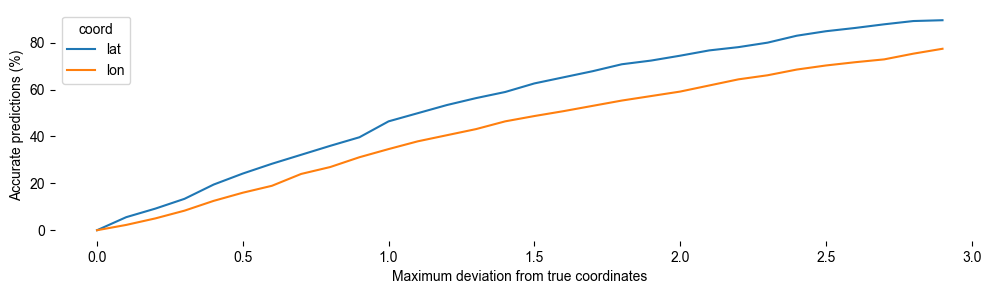

In [64]:
plt.rcParams["figure.figsize"] = (12,3)
d = pd.DataFrame({"accurate": legit_lat+legit_lon, 'threshold':thresholds+thresholds, 'coord':['lat']*len(thresholds)+['lon']*len(thresholds)})
ax = sns.lineplot(d, y="accurate", x="threshold", hue='coord')
ax.set(ylabel="Accurate predictions (%)", xlabel="Maximum deviation from true coordinates");
sns.set_style('darkgrid'); sns.despine(left=True, bottom=True)

In [65]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

* n-grams pushing $\uparrow$ north (higher lat)


In [66]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

feature        lat        lon
71702   υ επή  12.459749 -11.680933
71701    υ επ  10.545870 -10.804042
55839   ου επ  10.545870 -10.804042
52874   ο κι'   7.225207 -15.260861
12967   άμουν   7.062660 -12.780372

* n-grams pushing $\downarrow$ south (lower lat)


In [67]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

feature        lat        lon
34063   ην επ -10.288823   9.750072
48392   ν επή  -7.632564   8.778155
19348   α τση  -5.759389   5.617747
28058    δια!  -5.695231   6.604579
52873   ο κι   -5.692840  14.570373

* n-grams pushing $\rightarrow$ east (higher lon)


In [68]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

feature       lat        lon
52873   ο κι  -5.692840  14.570373
7221       τζ -1.824958   9.878273
51511    ντην -2.153183   9.855783
14940   έντην -2.153183   9.855783
51512   ντην  -2.153183   9.855783

* n-grams pushing $\leftarrow$ west (lower lon)


In [69]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

feature        lat        lon
52874   ο κι'   7.225207 -15.260861
33272   η μισ   5.760005 -13.264599
12967   άμουν   7.062660 -12.780372
47445   μουν    5.772356 -11.833586
71702   υ επή  12.459749 -11.680933

# Proverb alteration

* We alread observed that duplicates exist, but near duplicates may also be present, due to spatial propagation.
* We investigate this hypothesis, by measuring the edit distance per proverb, using ones co-existing in many areas.

In [70]:
highly_distr = duplicates.sort_values(by='area_num', ascending=False).head(3)
highly_distr

place   
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Ρούμελη, Πήλιο, Ζαγορά, Ήπειρος, Κύπρος, Λευκ...  \
Στου κουφού την πόρτα όσο θέλεις βρόντα         {Ρούμελη, Άνδρος, Κοζάνη, Βόϊο, Διαλεκτό, Καστ...   
Ανεμομαζώματα, διαβολοσκορπίσματα               {Ήπειρος, Μικρά Ασία, Κύζικος, Αρτάκη, Ήπειρος...   

                                                place_num   
text                                                        
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει         45  \
Στου κουφού την πόρτα όσο θέλεις βρόντα                26   
Ανεμομαζώματα, διαβολοσκορπίσματα                      28   

                                                                                             area   
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Ρούμελη, Ήπειρος, Εύβοια, Νίσυρος, Αρκαδία, Μ...  \
Στου κουφού την πόρτα όσο θέλεις βρόντα         {Ρούμελη, Άνδρος, Αρκαδία, Νίσυρος, Ιωάννινα, ...   
Ανεμομαζώματα, διαβολοσκορπίσματα               {Ήπειρος, Δαρδανέλλια (Ελλήσποντος), Εύβοια, Α...   

                                                area_num  prediction   
text                                                                   
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει        23      Σκύρος  \
Στου κουφού την πόρτα όσο θέλεις βρόντα               20  Μικρά Ασία   
Ανεμομαζώματα, διαβολοσκορπίσματα                     18  Μικρά Ασία   

                                                confidence   
text                                                         
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει    0.082260  \
Στου κουφού την πόρτα όσο θέλεις βρόντα           0.102971   
Ανεμομαζώματα, διαβολοσκορπίσματα                 0.075515   

                                                                                           latlon  
text                                                                                               
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  [(35.4049682, 24.7001033), (37.9982534, 23.737...  
Στου κουφού την πόρτα όσο θέλεις βρόντα         [(35.4049682, 24.7001033), (37.8408347, 24.862...  
Ανεμομαζώματα, διαβολοσκορπίσματα               [(37.9982534, 23.7378671), (40.3376058, 26.640...

Measuring the edit distance between each of this and all other (non-duplicate) proverbs

In [71]:
%%capture
!pip install python-Levenshtein
from Levenshtein import distance as lev

In [72]:
i = 0
target = highly_distr.reset_index().iloc[i].text
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
near_duplicates = near_duplicates.sort_values("lev", ascending=False)
near_duplicates.head(20)

text   
57545     Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει  \
12296        Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακά   
12297       Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακκά   
101159  Η γλώσσα κόκκαλα δεν έχει τσαι κόκκαλα τσατσίζει   
91835       Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'   
65997       Η γλώσσα κόκκαλα δεν έχ' κι κόκκαλα τσ'κίζει   
37378         Η γλώσσα κόκκαλα δεν έχει κόκκαλα τσακίζει   
61122       Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'   
60624       Γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει   
96914       Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί   
63213       Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί   
4879        Η γλώσσα κόκκαλα δεν έχι και κόκκαλα τσακίζ'   
54176       Γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει   
28103       Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί   
8950       Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει   
19761      Η γλώσσα κόκκαλα δεν έχει μα κόκκαλα τσακίζει   
14089   Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακίζει   
14088   Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακίζει   
119125    Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζ'ει   
114131   Η γλώσσα κόκκαλα δεν έχει, και κόκκαλα τσακίζει   

                               place   
57545                         Κύπρος  \
12296                          Ρόδος   
12297                          Ρόδος   
101159                        Σκύρος   
91835                 Θράκη, Μάδυτος   
65997             Νάουσα, Στενήμαχος   
37378               Θράκη, Περιστερά   
61122         Θράκη, Μάλγαρα, Αλμαλή   
60624                   Αδριανούπολη   
96914                Θράκη, Σωζόπολη   
63213    Κρήτη, Ινναχώριο, Περιβόλια   
4879        Θράκη, Σαράντα Εκκλησίες   
54176                   Αδριανούπολη   
28103                   Θράκη, Βιζύη   
8950            Μακεδονία, Βογατσικό   
19761   Μακεδονία, Σισάνι, Λιμπόχοβο   
14089                      Κως, Πυλί   
14088                      Κως, Πυλί   
119125             Κοζάνη, Καταφύγιο   
114131                     Μακεδονία   

                                              uri   
57545   http://hdl.handle.net/20.500.11853/193359  \
12296   http://hdl.handle.net/20.500.11853/170697   
12297   http://hdl.handle.net/20.500.11853/186599   
101159  http://hdl.handle.net/20.500.11853/195491   
91835   http://hdl.handle.net/20.500.11853/165008   
65997   http://hdl.handle.net/20.500.11853/161010   
37378   http://hdl.handle.net/20.500.11853/164689   
61122   http://hdl.handle.net/20.500.11853/164281   
60624   http://hdl.handle.net/20.500.11853/168157   
96914   http://hdl.handle.net/20.500.11853/191796   
63213   http://hdl.handle.net/20.500.11853/161199   
4879    http://hdl.handle.net/20.500.11853/169165   
54176   http://hdl.handle.net/20.500.11853/168157   
28103   http://hdl.handle.net/20.500.11853/164735   
8950    http://hdl.handle.net/20.500.11853/165301   
19761   http://hdl.handle.net/20.500.11853/172414   
14089   http://hdl.handle.net/20.500.11853/195775   
14088   http://hdl.handle.net/20.500.11853/179636   
119125  http://hdl.handle.net/20.500.11853/181938   
114131  http://hdl.handle.net/20.500.11853/169483   

                             collector          area        lat        lon   
57545               Κυριαζής, Νίκος Γ.        Κύπρος  34.982302  33.145128  \
12296           Δρακίδης, Γεράσιμος Δ.         Ρόδος  36.172630  27.919418   
12297           Δρακίδης, Γεράσιμος Δ.         Ρόδος  36.172630  27.919418   
101159                Περδίκα, Νίκη Λ.        Σκύρος  38.873044  24.524477   
91835        Οικονομίδης, Απόστολος Β.         Θράκη  40.846424  25.875938   
65997           Λουκάτος, Δημήτριος Σ.        Νάουσα  40.630870  22.070413   
37378              Καλλίας, Λάμπρος Γ.         Θράκη  40.846424  25.875938   
61122         Κωνσταντινίδης, Θεόδωρος         Θράκη  40.846424  25.875938   
60624               Κωνσταντινίδης, Γ.  Αδριανούπολη  41.675933  26.558722   
96914   Παπαϊωαννίδης, Κωνσταντίνος Δ.         Θράκη  40

* Finding areas in the near duplicates but not in the (exact text) duplicates

In [73]:
new_areas = set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas))
print(new_areas)

6
{'Ρόδος', 'Μακεδονία', 'Νάουσα', 'Κως', 'Αδριανούπολη', 'Σκύρος'}


* Checking if an indirect path between two places is as short or shorter than the direct path.

In [74]:
import networkx as nx

# Check that a list has no two consecutive duplicates.
# That will be used later on to ensure that we do not
# move from a place to the same place.
def has_no_consecutive_duplicates(lst):
    for a, b in zip(lst, lst[1:]):
        if a == b:
            return False
    return True

# Calculate direct distances matrix.

def find_indirect_paths(near_duplicates):
    n = len(near_duplicates)
    direct_dist_matrix = np.zeros((n, n))

    for u in range(n):
        for v in range(n):
            direct_dist_matrix[u, v] = lev(near_duplicates['text'].iloc[u], near_duplicates['text'].iloc[v])

    # Now calculate shortest paths, not necessarily direct.

    dist_matrix = np.zeros((n, n))
    G = nx.from_numpy_array(direct_dist_matrix, parallel_edges=False, create_using=nx.Graph)

    shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
    indirect_shortest_paths = {}
    num_indirect_shortest_paths = 0
    for u in range(n):
        for v in range(n):
            u_v_shortest_paths = nx.all_shortest_paths(G, u, v, weight='weight')
            for path in u_v_shortest_paths:
                if len(path) > 2:
                    if u not in indirect_shortest_paths:
                        indirect_shortest_paths[u] = { }
                    if v not in indirect_shortest_paths[u]:
                        indirect_shortest_paths[u][v] = []
                    indirect_shortest_paths[u][v].append(path)
                    num_indirect_shortest_paths += 1
            if direct_dist_matrix[u][v] != 0:
                dist_matrix[u][v] = shortest_path_lengths[u][v]

    for u, v_paths in indirect_shortest_paths.items():
        clean_pahts = []
        for v, paths in v_paths.items():
            decoded_paths = [ 
                [near_duplicates['area'].iloc[node] for node in path] 
                for path in paths
            ]
            proverb_paths = [
                [near_duplicates['text'].iloc[node] for node in path] 
                for path in paths
            ]
            print(f'shortest indirect paths {u}->{v}:')
            print(f'{paths}: {decoded_paths}')
            non_trivial_paths = []
            non_trivial_decoded_paths = []
            non_trival_proverb_paths = []
            for (p, dp, pp) in zip(paths, decoded_paths, proverb_paths):
                if has_no_consecutive_duplicates(dp) and dp[0] != dp[-1]:
                    non_trivial_paths.append(p)
                    non_trivial_decoded_paths.append(dp)
                    non_trival_proverb_paths.append(pp)
            print('shortest non trivial paths')
            if len(non_trivial_decoded_paths) > 0:
                print(non_trivial_paths)
                print(non_trivial_decoded_paths)
                print(non_trival_proverb_paths)
            else:
                print('None')

In [75]:
find_indirect_paths(near_duplicates)

shortest indirect paths 0->4:
[[0, 14, 4], [0, 11, 4]]: [['Κύπρος', 'Μακεδονία', 'Θράκη'], ['Κύπρος', 'Θράκη', 'Θράκη']]
shortest non trivial paths
[[0, 14, 4]]
[['Κύπρος', 'Μακεδονία', 'Θράκη']]
[['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει', "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει", "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'"]]
shortest indirect paths 0->5:
[[0, 20, 5], [0, 14, 5]]: [['Κύπρος', 'Ρούμελη', 'Νάουσα'], ['Κύπρος', 'Μακεδονία', 'Νάουσα']]
shortest non trivial paths
[[0, 20, 5], [0, 14, 5]]
[['Κύπρος', 'Ρούμελη', 'Νάουσα'], ['Κύπρος', 'Μακεδονία', 'Νάουσα']]
[['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει', 'Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζει', "Η γλώσσα κόκκαλα δεν έχ' κι κόκκαλα τσ'κίζει"], ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει', "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει", "Η γλώσσα κόκκαλα δεν έχ' κι κόκκαλα τσ'κίζει"]]
shortest indirect paths 0->7:
[[0, 14, 7], [0, 11, 7]]: [['Κύπρος', 'Μακεδονία', 'Θράκη'], ['Κύπρος', 'Θράκη'

In [76]:
i = 1
target = highly_distr.reset_index().iloc[i].text
print(target)
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
new_areas = set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas))
print(new_areas)
near_duplicates = near_duplicates.sort_values("lev", ascending=False)
near_duplicates.head(20)

Στου κουφού την πόρτα όσο θέλεις βρόντα
19
{'Λέσβος', 'Ήπειρος', 'Εύβοια', 'Κάρπαθος', 'Μικρά Ασία', 'Μακεδονία', 'Αδριανούπολη', 'Κορινθία', 'Ρόδος', 'Αχαΐα', 'Μήλος', 'Χίος', 'Κέρκυρα', 'Δαρδανέλλια (Ελλήσποντος)', 'Αργολίδα', 'Ηλεία', 'Σάμος', 'Κως', 'Κύπρος'}


text   
68433       Τού κουφού την πόρτα, όσο θέλεις βρόντα  \
109128     Σ' τού κουφού τη πόρτα όσο θέλεις βρόντα   
67811      Στου κουφού την πόρτα, όσο θέλης βρόντα!   
76273   Σ του κουφού την πόρταν, όσον θέλεις βρόντα   
60899      Σ του κουφού την πόρτα όσον θέλ'ς βρόντα   
54444      Σ του κουφού την πόρτα όσον θέλ'ς βρόντα   
51929       Στου κουφού τημ πόρτα όσο θέλης βρόντα!   
45769         Στου κουφού τη bόρτα όσο θέλεις βρόdα   
67810        Στου κουφού την bόρτα όσο θέλεις βρόdα   
78524       Στου κουφού τη bόρτα, όσο θέλεις βρόντα   
62367     Στου κουφού την πόρταν, όσα θέλεις βρόντα   
28390       Στου κουφού τη μπόρτα όσο θελεις βρόντα   
55784    Σ του κουφού την πόρταν όσον θέλεις βρόντα   
13201        Στου κουφού τημ πόρτα όσο θέλης βρόντα   
114762      Στου κωφού την πόρτα, όσο θέλεις βρόντα   
9704         Στου κουφού την μπόρτα όσο θέλς βρόντα   
9867         Τού κουφού την πόρτα όσο θέλεις βρόντα   
19591     Στου κουφού την πόρταν, όσο θέλεις βρόντα   
7261        Στου κουφού τη πόρτα, όσο θέλεις βρόντα   
76308       Στου κουφού τη πόρταν όσο θέλεις βρόντα   

                                 place   
68433                 Λέσβος, Αγιάσσος  \
109128               Κορινθία, Τρίκαλα   
67811               Κέρκυρα, Ερείκουσα   
76273                         Κάρπαθος   
60899                     Αδριανούπολη   
54444                     Αδριανούπολη   
51929                     Αχαΐα, Πάτρα   
45769                 Νάξος, Γαλανάδες   
67810                           Λέσβος   
78524     Αργολίδα, Ερμιονίδα, Κρανίδι   
62367   Μικρά Ασία, Λιβίσσι (Λειβίσσι)   
28390                            Σάμος   
55784                    Κύπρος, Κοίλη   
13201                            Ρόδος   
114762                       Μακεδονία   
9704                    Θράκη, Αυδήμιο   
9867                           Ρούμελη   
19591               Κύπρος, Λευκόνοικο   
7261            Κοζάνη, Βόϊο, Γαλατινή   
76308                         Κάρπαθος   

                                              uri                   collector   
68433   http://hdl.handle.net/20.500.11853/273208      Λουκάτος, Δημήτριος Σ.  \
109128  http://hdl.handle.net/20.500.11853/273607          Σταματούλης, Ι. Π.   
67811   http://hdl.handle.net/20.500.11853/274536      Λουκάτος, Δημήτριος Σ.   
76273   http://hdl.handle.net/20.500.11853/231044      Μανωλακάκης, Εμμανουήλ   
60899   http://hdl.handle.net/20.500.11853/273623          Κωνσταντινίδης, Γ.   
54444   http://hdl.handle.net/20.500.11853/273623  Κουρτίδης, Κωνσταντίνος Γ.   
51929   http://hdl.handle.net/20.500.11853/274394        Κορύλλος, Χρήστος Π.   
45769   http://hdl.handle.net/20.500.11853/273224               Κορακίτης, Δ.   
67810   http://hdl.handle.net/20.500.11853/273204      Λουκάτος, Δημήτριος Σ.   
78524   http://hdl.handle.net/20.500.11853/274520           Μερεμέτη, Δήμητρα   
62367   http://hdl.handle.net/20.500.11853/274360    Λαμέρας, Κωνσταντίνος Γ.   
28390   http://hdl.handle.net/20.500.11853/273609      Ιωαννίδης, Σωκράτης Ν.   
55784   http://hdl.handle.net/20.500.11853/273252         Κυκκότης, Ιερώνυμος   
13201   http://hdl.handle.net/20.500.11853/273746      Δρακίδης, Γεράσιμος Δ.   
114762  http://hdl.handle.net/20.500.11853/273674             Τσικόπουλος, Ι.   
9704    http://hdl.handle.net/20.500.11853/227671        Δεληγιάννης, Βασίλης   
9867    http://hdl.handle.net/20.500.11853/274346        Δελούση, Αθανασία Γ.   
19591   http://hdl.handle.net/20.500.11853/274544           Ηλιάδης, Γεώργιος   
7261    http://hdl.handle.net/20.500.11853/274573     Βουζιανάς, Κωνσταντίνος   
76308   http://hdl.handle.net/20.500.11853/273688      Μανωλακάκης, Εμμανουήλ   

                area        lat        lon  lev  
68433         Λέσβος  39.175842  25.998913    4  
109128      Κορινθία  37.962991  22.733342    4  
67811        Κέρκυρα  39.645253  19.859955    4  
76273       Κάρπαθος  35.613661  27.119257    4  
60899   Αδριανούπολη  41.675933  26.558722    4  
54444 

In [77]:
find_indirect_paths(near_duplicates)

shortest indirect paths 0->1:
[[0, 16, 1]]: [['Λέσβος', 'Ρούμελη', 'Κορινθία']]
shortest non trivial paths
[[0, 16, 1]]
[['Λέσβος', 'Ρούμελη', 'Κορινθία']]
[['Τού κουφού την πόρτα, όσο θέλεις βρόντα', 'Τού κουφού την πόρτα όσο θέλεις βρόντα', "Σ' τού κουφού τη πόρτα όσο θέλεις βρόντα"]]
shortest indirect paths 0->2:
[[0, 38, 2], [0, 43, 2], [0, 45, 2], [0, 46, 2], [0, 47, 2], [0, 48, 2], [0, 49, 2], [0, 51, 2], [0, 52, 2], [0, 54, 2], [0, 58, 2], [0, 59, 2]]: [['Λέσβος', 'Θράκη', 'Κέρκυρα'], ['Λέσβος', 'Αρκαδία', 'Κέρκυρα'], ['Λέσβος', 'Λακωνία', 'Κέρκυρα'], ['Λέσβος', 'Μικρά Ασία', 'Κέρκυρα'], ['Λέσβος', 'Μικρά Ασία', 'Κέρκυρα'], ['Λέσβος', 'Κρήτη', 'Κέρκυρα'], ['Λέσβος', 'Μικρά Ασία', 'Κέρκυρα'], ['Λέσβος', 'Κρήτη', 'Κέρκυρα'], ['Λέσβος', 'Ηλεία', 'Κέρκυρα'], ['Λέσβος', 'Θεσπρωτία', 'Κέρκυρα'], ['Λέσβος', 'Άνδρος', 'Κέρκυρα'], ['Λέσβος', 'Θράκη', 'Κέρκυρα']]
shortest non trivial paths
[[0, 38, 2], [0, 43, 2], [0, 45, 2], [0, 46, 2], [0, 47, 2], [0, 48, 2], [0, 49, 2], [0, 51, 2], [0,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



shortest indirect paths 34->24:
[[34, 37, 24], [34, 40, 24], [34, 41, 24], [34, 44, 24], [34, 50, 24], [34, 53, 24], [34, 55, 24], [34, 57, 24], [34, 20, 24], [34, 37, 20, 24], [34, 41, 20, 24], [34, 44, 20, 24], [34, 50, 20, 24], [34, 55, 20, 24], [34, 57, 20, 24], [34, 21, 24], [34, 37, 21, 24], [34, 41, 21, 24], [34, 44, 21, 24], [34, 50, 21, 24], [34, 55, 21, 24], [34, 57, 21, 24], [34, 26, 24], [34, 37, 26, 24], [34, 41, 26, 24], [34, 44, 26, 24], [34, 50, 26, 24], [34, 55, 26, 24], [34, 57, 26, 24], [34, 32, 24], [34, 37, 32, 24], [34, 41, 32, 24], [34, 44, 32, 24], [34, 50, 32, 24], [34, 55, 32, 24], [34, 57, 32, 24], [34, 12, 24], [34, 37, 12, 24], [34, 41, 12, 24], [34, 44, 12, 24], [34, 50, 12, 24], [34, 55, 12, 24], [34, 57, 12, 24], [34, 20, 12, 24], [34, 37, 20, 12, 24], [34, 41, 20, 12, 24], [34, 44, 20, 12, 24], [34, 50, 20, 12, 24], [34, 55, 20, 12, 24], [34, 57, 20, 12, 24], [34, 21, 12, 24], [34, 37, 21, 12, 24], [34, 41, 21, 12, 24], [34, 44, 21, 12, 24], [34, 50, 21

shortest indirect paths 53->5:
[[53, 34, 5], [53, 37, 5], [53, 34, 37, 5], [53, 41, 5], [53, 34, 41, 5], [53, 42, 5], [53, 44, 5], [53, 34, 44, 5], [53, 50, 5], [53, 34, 50, 5], [53, 55, 5], [53, 34, 55, 5], [53, 57, 5], [53, 34, 57, 5], [53, 21, 5], [53, 34, 21, 5], [53, 37, 21, 5], [53, 34, 37, 21, 5], [53, 41, 21, 5], [53, 34, 41, 21, 5], [53, 42, 21, 5], [53, 44, 21, 5], [53, 34, 44, 21, 5], [53, 50, 21, 5], [53, 34, 50, 21, 5], [53, 55, 21, 5], [53, 34, 55, 21, 5], [53, 57, 21, 5], [53, 34, 57, 21, 5], [53, 26, 5], [53, 34, 26, 5], [53, 37, 26, 5], [53, 34, 37, 26, 5], [53, 41, 26, 5], [53, 34, 41, 26, 5], [53, 42, 26, 5], [53, 44, 26, 5], [53, 34, 44, 26, 5], [53, 50, 26, 5], [53, 34, 50, 26, 5], [53, 55, 26, 5], [53, 34, 55, 26, 5], [53, 57, 26, 5], [53, 34, 57, 26, 5], [53, 32, 5], [53, 34, 32, 5], [53, 37, 32, 5], [53, 34, 37, 32, 5], [53, 41, 32, 5], [53, 34, 41, 32, 5], [53, 42, 32, 5], [53, 44, 32, 5], [53, 34, 44, 32, 5], [53, 50, 32, 5], [53, 34, 50, 32, 5], [53, 55, 32, 

In [78]:
i = 2
target = highly_distr.reset_index().iloc[i].text
print(target)
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
new_areas = set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas))
print(new_areas)
near_duplicates = near_duplicates.sort_values("lev", ascending=False)
near_duplicates.head(20)

Ανεμομαζώματα, διαβολοσκορπίσματα
17
{'Ρούμελη', 'Αιτωλοακαρνανία', 'Θεσσαλία', 'Ρόδος', 'Ανατολική Θράκη', 'Λακωνία', 'Σάμος', 'Νίσυρος', 'Κεφαλληνία', 'Βοιωτία', 'Σκύρος', 'Φιλιππούπολη', 'Θεσπρωτία', 'Ημαθία', 'Ιωάννινα', 'Κύπρος', 'Επτάνησος'}


text                           place   
79527       Ανεμουμαζώματα διαβοσκορπίσματα  Μικρά Ασία, Λιβίσσι (Λειβίσσι)  \
94119     Ανεμομαζώματα, δαιμονοσκορπίσματα                   Κρήτη, Σητεία   
98218   Ανεμομαζώματα διαβουλουσκουρπίσματα                    Αδριανούπολη   
100770    Ανεμομαζώματα, δαιμονοσκορπίσματα                          Σκύρος   
62444    Ανιμουμαζώματα διαβουλοσκορπίσματα                    Αδριανούπολη   
56358     Ανεμομαζώματα, δαιμονοσκορπίσματα                          Κύπρος   
11947       Ανεμομαδέματα διαολοσκορπίσματα                           Ρόδος   
41532      Ανεμομαζώματα, δαιμοοσκορπίσματα                        Ιωάννινα   
36061   Ανεμομαζέματα, δια(β)ολοσκορπίσματα                         Νίσυρος   
98217      Ανεμομάζωματα, διαολοσκορπίσματα        Θράκη, Σαράντα Εκκλησίες   
120398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
121398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
42356       Ανεμομαξώματα διαολοσκορπίσματα         Κρήτη, Ρέθυμνο, Μαλλάκι   
122398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
134398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
124398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
129398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
133398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
132398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
131398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   

                                              uri   
79527   http://hdl.handle.net/20.500.11853/153830  \
94119   http://hdl.handle.net/20.500.11853/189090   
98218   http://hdl.handle.net/20.500.11853/196946   
100770  http://hdl.handle.net/20.500.11853/195161   
62444   http://hdl.handle.net/20.500.11853/186040   
56358   http://hdl.handle.net/20.500.11853/194481   
11947   http://hdl.handle.net/20.500.11853/142563   
41532   http://hdl.handle.net/20.500.11853/147957   
36061   http://hdl.handle.net/20.500.11853/186837   
98217   http://hdl.handle.net/20.500.11853/197065   
120398  http://hdl.handle.net/20.500.11853/185814   
121398  http://hdl.handle.net/20.500.11853/185814   
42356   http://hdl.handle.net/20.500.11853/148071   
122398  http://hdl.handle.net/20.500.11853/185814   
134398  http://hdl.handle.net/20.500.11853/185814   
124398  http://hdl.handle.net/20.500.11853/185814   
129398  http://hdl.handle.net/20.500.11853/185814   
133398  http://hdl.handle.net/20.500.11853/185814   
132398  http://hdl.handle.net/20.500.11853/185814   
131398  http://hdl.handle.net/20.500.11853/185814   

                          collector          area        lat        lon  lev  
79527                      Μουσαίος    Μικρά Ασία  38.184637  23.512277    4  
94119              Παπαδάκη, Ειρήνη         Κρήτη  35.308495  24.463342    4  
98218   Παπαχριστοδούλου, Πολύδωρος  Αδριανούπολη  41.675933  26.558722    4  
100770             Περδίκα, Νίκη Λ.        Σκύρος  38.873044  24.524477    4  
62444     Λαμπουσιάδης, Γεώργιος Ι.  Αδριανούπολη  41.675933  26.558722    4  
56358            Κυριαζής, Νίκος Γ.        Κύπρος  34.982302  33.145128    4  
11947        Δρακίδης, Γεράσιμος Δ.         Ρόδος  36.172630  27.919418    4  
41532         Κατζιούλης, Παρθένιος      Ιωάννινα  39.663982  20.852278    4  
36061          Καζαβής, Γεώργιος Ν.       Νίσυρος  36.589046  27.169184    3  
98217   Παπαχριστοδούλου, Πολύδωρος         Θράκη  40.846424  25.875938    3  
120398                    anonymous         Σάμος  37.724616  26.819292    3  
121398                    anonymous         Σάμος  37.724616  26.819292    3  
42356          Κλαζινού, Αικατερίνη         Κρήτη  35.308495  24.463342    3  
122398                    anonymous         Σάμος  37.724616  26.819292    3  
134398                    anonymous         Σάμος  37.724616  26.819292    3  
1

In [79]:
find_indirect_paths(near_duplicates)

shortest indirect paths 0->1:
[[0, 7, 1]]: [['Μικρά Ασία', 'Ιωάννινα', 'Κρήτη']]
shortest non trivial paths
[[0, 7, 1]]
[['Μικρά Ασία', 'Ιωάννινα', 'Κρήτη']]
[['Ανεμουμαζώματα διαβοσκορπίσματα', 'Ανεμομαζώματα, δαιμοοσκορπίσματα', 'Ανεμομαζώματα, δαιμονοσκορπίσματα']]
shortest indirect paths 0->2:
[[0, 42, 2], [0, 43, 2], [0, 44, 2], [0, 45, 2], [0, 48, 2], [0, 49, 2], [0, 50, 2], [0, 51, 2], [0, 52, 2], [0, 54, 2], [0, 56, 2], [0, 57, 2], [0, 58, 2], [0, 60, 2], [0, 62, 2], [0, 63, 2]]: [['Μικρά Ασία', 'Θράκη', 'Αδριανούπολη'], ['Μικρά Ασία', 'Κοζάνη', 'Αδριανούπολη'], ['Μικρά Ασία', 'Λακωνία', 'Αδριανούπολη'], ['Μικρά Ασία', 'Λακωνία', 'Αδριανούπολη'], ['Μικρά Ασία', 'Αρκαδία', 'Αδριανούπολη'], ['Μικρά Ασία', 'Μακεδονία', 'Αδριανούπολη'], ['Μικρά Ασία', 'Αρκαδία', 'Αδριανούπολη'], ['Μικρά Ασία', 'Μικρά Ασία', 'Αδριανούπολη'], ['Μικρά Ασία', 'Ανατολική Θράκη', 'Αδριανούπολη'], ['Μικρά Ασία', 'Ημαθία', 'Αδριανούπολη'], ['Μικρά Ασία', 'Μικρά Ασία', 'Αδριανούπολη'], ['Μικρά Ασία', 'Μικρά

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



shortest indirect paths 25->32:
[[25, 29, 32], [25, 30, 32], [25, 33, 32], [25, 37, 32], [25, 42, 32], [25, 29, 42, 32], [25, 30, 42, 32], [25, 33, 42, 32], [25, 37, 42, 32], [25, 43, 32], [25, 29, 43, 32], [25, 30, 43, 32], [25, 33, 43, 32], [25, 37, 43, 32], [25, 44, 32], [25, 29, 44, 32], [25, 30, 44, 32], [25, 33, 44, 32], [25, 37, 44, 32], [25, 45, 32], [25, 29, 45, 32], [25, 30, 45, 32], [25, 33, 45, 32], [25, 37, 45, 32], [25, 48, 32], [25, 29, 48, 32], [25, 30, 48, 32], [25, 33, 48, 32], [25, 37, 48, 32], [25, 49, 32], [25, 29, 49, 32], [25, 30, 49, 32], [25, 33, 49, 32], [25, 37, 49, 32], [25, 50, 32], [25, 29, 50, 32], [25, 30, 50, 32], [25, 33, 50, 32], [25, 37, 50, 32], [25, 51, 32], [25, 29, 51, 32], [25, 30, 51, 32], [25, 33, 51, 32], [25, 37, 51, 32], [25, 52, 32], [25, 29, 52, 32], [25, 30, 52, 32], [25, 33, 52, 32], [25, 37, 52, 32], [25, 54, 32], [25, 29, 54, 32], [25, 30, 54, 32], [25, 33, 54, 32], [25, 37, 54, 32], [25, 56, 32], [25, 29, 56, 32], [25, 30, 56, 32], [

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Agglomerative clustering

* Besides duplicate proverbs, near-duplicates also exist, probably due to the spatial propagation of proverbs over time. 
* We employ linguistic distance to estimate the route of a proverb, assuming that shorter travels lead to fewer edits.   


```
input: proverb target, threshold e
output: the target's dendrogram
1. for proverb in proverbs:
2.   dist[proverb] = edit_distance(proverb, target)
3. sort(dist, ascending=True)
4. filtered = [p in dist if dist[p]<e] 
5. representations = TFIDF(filtered)
6. dendrogram = Ward(representations)
```

* Exploring the three targets discussed above.
* Fetching versions up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [80]:
target = highly_distr.reset_index().iloc[1].text.lower()
target

'στου κουφού την πόρτα όσο θέλεις βρόντα'

* Fetching proverbs up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [81]:
from Levenshtein import distance as lev
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))

In [82]:
close_candidates = candidates[candidates.lev < 20]
close_candidates.sample(5)

text                     place   
64604   Στου κουφού την πόρτα, όσο θέλεις βρόντα           Λακωνία, Σπάρτη  \
109128  Σ' τού κουφού τη πόρτα όσο θέλεις βρόντα         Κορινθία, Τρίκαλα   
73771   Σ του κουφού την πόρτα όσο θέλεις βρόντα              Θράκη, Αίνος   
104243  Σ του κουφού την πόρτα όσο θέλεις βρόντα                     Μήλος   
55672   Στου κουφού την πόρτα, όσο θέλεις βρόντα  Κρήτη, Ιεράπετρα, Βαϊνιά   

                                              uri   
64604   http://hdl.handle.net/20.500.11853/273127  \
109128  http://hdl.handle.net/20.500.11853/273607   
73771   http://hdl.handle.net/20.500.11853/273630   
104243  http://hdl.handle.net/20.500.11853/272985   
55672   http://hdl.handle.net/20.500.11853/274602   

                           collector      area        lat        lon  lev  
64604                Λιουδάκη, Μαρία   Λακωνία  36.760279  22.790464    2  
109128            Σταματούλης, Ι. Π.  Κορινθία  37.962991  22.733342    5  
73771         Μανασσείδης, Συμεών Α.     Θράκη  40.846424  25.875938    2  
104243               Ράμφος, Άγγελος     Μήλος  36.709344  24.506834    2  
55672   Κυδωνάκη – Μαστοράκη, Ειρήνη     Κρήτη  35.308495  24.463342    2

* Hierarchically clustering the candidate versions of our target proverb
* Employing single linkage, using the minimum distance between the proverbs of two clusters as a criterion for merging.
* Based on the assumption that the fewer edits reflect the chosen route.  

In [83]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

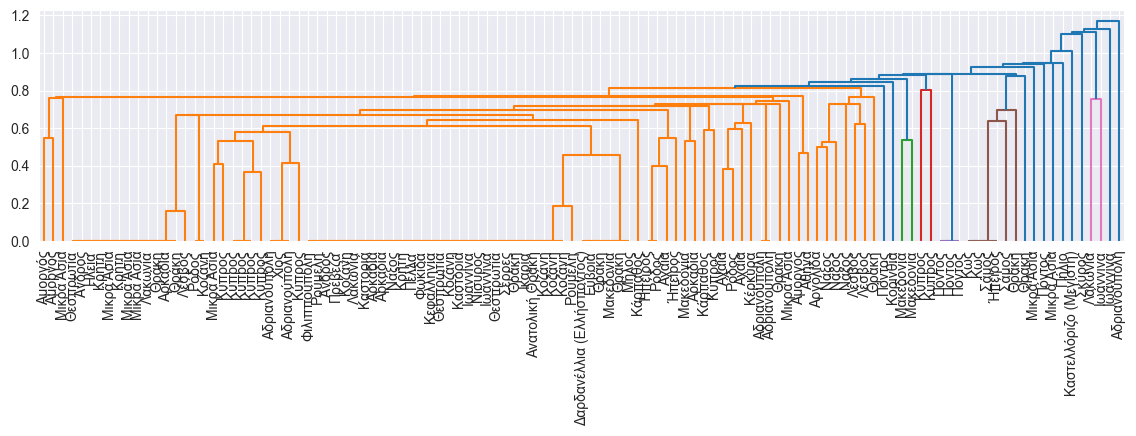

In [84]:
vec = TfidfVectorizer(analyzer="char", ngram_range=(2,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform(close_candidates.text.values)
Z = linkage(X.toarray(), 'single')
fig = plt.figure(figsize=(14, 3))
ax = dendrogram(Z, orientation='top', labels=close_candidates.area.values, distance_sort='descending', show_leaf_counts=False, leaf_font_size=10., show_contracted=True);
fig.savefig('deaf_man_door.pdf', format="PDF", dpi=300)

* To better understand the clustering, we create a dataframe and filter based on distance

In [85]:
clustering = fcluster(Z, t=0.4, criterion='distance')
close_candidates.insert(6, "clustering", clustering)
#close_candidates["clustering"] = clustering
grouped = close_candidates.groupby("clustering")
clusters = pd.DataFrame({"cluster":grouped.area.apply(list), "text":grouped.text.apply(list)})
clusters[clusters.cluster.apply(len)>1]

cluster   
clustering                                                      
3                                  [Κως, Κως, Σάμος, Ήπειρος]  \
7                                    [Πόντος, Πόντος, Πόντος]   
21                               [Αδριανούπολη, Αδριανούπολη]   
22                                             [Ρόδος, Αχαΐα]   
29                                    [Ρόδος, Αχαΐα, Ήπειρος]   
31          [Εύβοια, Δαρδανέλλια (Ελλήσποντος), Θράκη, Μακ...   
32          [Ρούμελη, Φιλιππούπολη, Άνδρος, Πρέβεζα, Κοζάν...   
33                         [Χίος, Αδριανούπολη, Αδριανούπολη]   
35                           [Κύπρος, Κύπρος, Κύπρος, Κύπρος]   
39                                            [Κοζάνη, Ρόδος]   
40          [Άνδρος, Θεσπρωτία, Ηλεία, Κρήτη, Μικρά Ασία, ...   

                                                         text  
clustering                                                     
3           [Στου κουφού τη μπόρτα όσο θέλεις βρόντα, Στου...  
7           [Σ ση κωφού τημ πόρταν όσον θέλεις βρόντα, Σ σ...  
21          [Σ του κουφού την πόρτα όσον θέλ'ς βρόντα, Σ τ...  
22          [Στου κουφού τημ πόρτα όσο θέλης βρόντα, Στου ...  
29          [Στου κουφού τημ πόρτα όσο θέλεις βρόντα, Σ το...  
31          [Σ του κουφού την πόρτα όσο θέλεις βρόντα, Σ τ...  
32          [Στου κουφού την πόρτα όσο θέλεις βρόντα, Στου...  
33          [Σ του κουφού την πόρτα όσον θέλεις βρόντα, Σ ...  
35          [Στου κουφού την πόρταν όσον θέλεις βρόντα, Σ ...  
39          [Στου κουφού τη πόρτα, όσο θέλεις βρόντα, Στου...  
40          [Στου κουφού την πόρτα, όσο θέλεις βρόντα, Στο...

In [86]:
# focus on clusters with more than one area
for i, row in clusters[clusters.cluster.apply(len)>1].iterrows():
    # hash to avoid duplicated areas (neighbouring proverbs)
    d = dict(list(zip(row.cluster, row.text)))
    if len(d)>1: # ignore duplicates
        # print the clustered versions  
        for place in d:
            print(f'{place} --> {d[place]}')
        print()

Κως --> Στου κουφού τη μπόρτα όσο θέλεις βρόντα
Σάμος --> Στου κουφού τη μπόρτα όσο θελεις βρόντα
Ήπειρος --> Στου κουφού τη μπόρτα όσο θέλεις βρόντα

Ρόδος --> Στου κουφού τημ πόρτα όσο θέλης βρόντα
Αχαΐα --> Στου κουφού τημ πόρτα όσο θέλης βρόντα!

Ρόδος --> Στου κουφού τημ πόρτα όσο θέλεις βρόντα
Αχαΐα --> Σ του κουφού τημ πόρτα όσο θέλεις βρόντα
Ήπειρος --> Στου κουφού τημ πόρτα όσο θέλεις βρόντα

Εύβοια --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Δαρδανέλλια (Ελλήσποντος) --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Θράκη --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Μακεδονία --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Μήλος --> Σ του κουφού την πόρτα όσο θέλεις βρόντα

Ρούμελη --> Τού κουφού την πόρτα όσο θέλεις βρόντα
Φιλιππούπολη --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Άνδρος --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Πρέβεζα --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Κοζάνη --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Λακωνία --> Στου κουφού την πόρτα όσο θέλεις βρόντα


# Proverb propagation

* A synthetic example to convey the picture of the indirect paths introduced above.
* Ιntroducing location-based noise sources, e.g., by adding a nasal (Cyrpus) or /k/>/ts/ (Crete).
* Then, altering proverbs by visiting virtually an area directly (adding noise of one type) or through other areas (adding multiple noises).

In [87]:
from Levenshtein import distance as lev

def nasal(txt):
    out = [ word+"ν" if word[-1] in {"ε","ο","η","α"} else word for word in txt.split() ]
    return " ".join(out)
    
def tsita(txt):
    return txt.replace("κ", "τσ")

source = "η παροιμία για τη παροιμία και τη παράδοση"
cyprus = nasal(source)
crete = tsita(source)
route = nasal(tsita(source))

print(f'{source} -> {cyprus}\n(Source -> Cyprus: {lev(source, cyprus)} edits)')
print(f'{source} -> {crete}\n(Source -> Crete: {lev(source, crete)} edits)')
print(f'{crete} -> {cyprus}\n(Crete -> Cyprus: {lev(crete, route)} edits)')
print(f'{source} -> {route}\n(Source -> Crete -> Cyrpus: {lev(source, route)} edits)')

η παροιμία για τη παροιμία και τη παράδοση -> ην παροιμίαν γιαν την παροιμίαν και την παράδοσην
(Source -> Cyprus: 7 edits)
η παροιμία για τη παροιμία και τη παράδοση -> η παροιμία για τη παροιμία τσαι τη παράδοση
(Source -> Crete: 2 edits)
η παροιμία για τη παροιμία τσαι τη παράδοση -> ην παροιμίαν γιαν την παροιμίαν και την παράδοσην
(Crete -> Cyprus: 7 edits)
η παροιμία για τη παροιμία και τη παράδοση -> ην παροιμίαν γιαν την παροιμίαν τσαι την παράδοσην
(Source -> Crete -> Cyrpus: 9 edits)


* There is a path (Source -> Crete -> Cyprus) whose sum of edit distances equals the distance between the two edges (Source -> Crete and Crete -> Cyprus). 

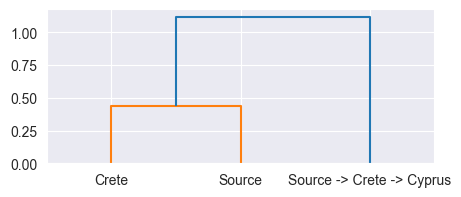

In [88]:
vec = TfidfVectorizer(analyzer="char", ngram_range=(2,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform([source, tsita(source), nasal(tsita(source))])
Z = linkage(X.toarray(), 'single')
fig = plt.figure(figsize=(5, 2))
ax = dendrogram(Z, 
                orientation='top', 
                labels=["Source", "Crete", "Source -> Crete -> Cyprus"], 
                distance_sort='descending', 
                show_leaf_counts=False, 
                leaf_font_size=10., 
                show_contracted=True)

* The Source proveb is near the Source>Cretan alteration (orange cluster)
* Which is near the Source>Cretan>Cypriotic alteration (blue link) 